<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

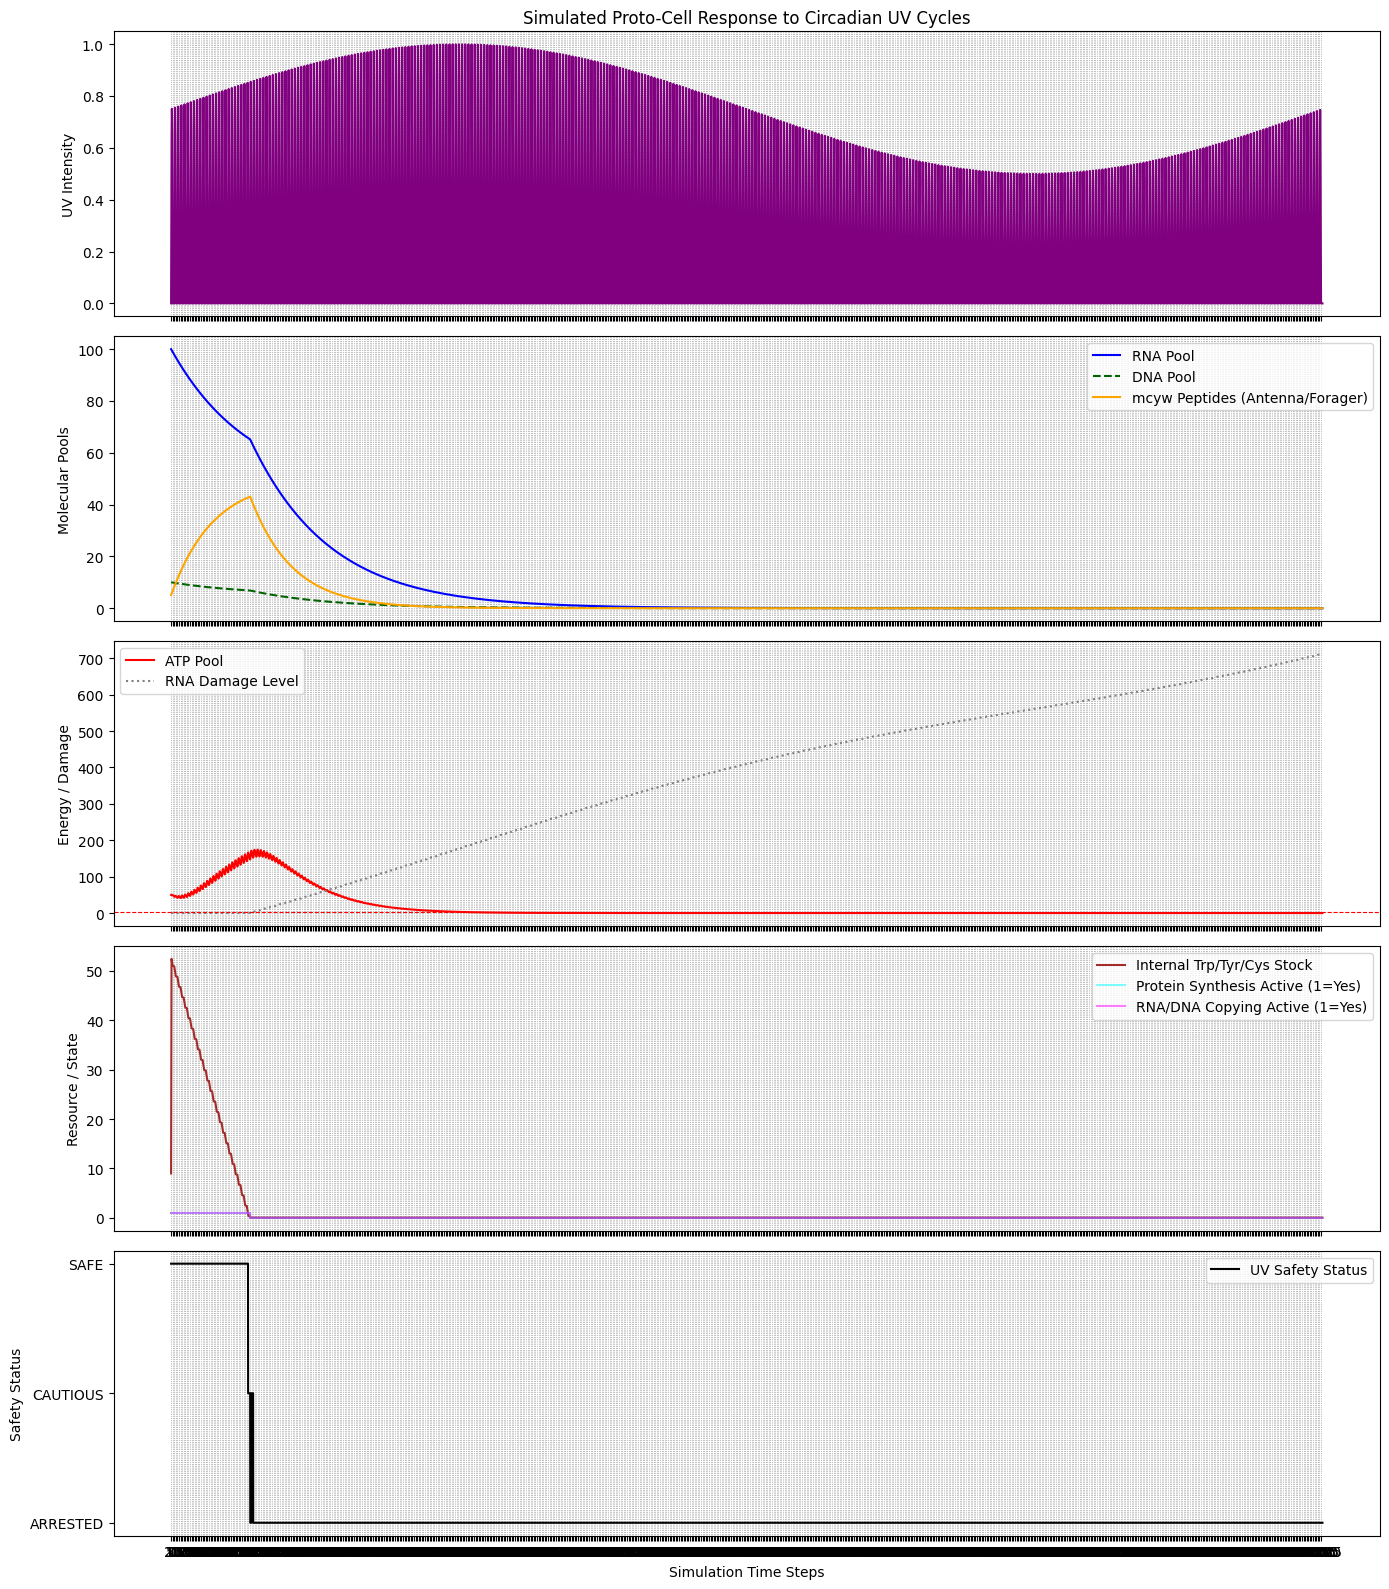

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for data handling and plotting

# --- 1. Environmental & Global Parameters ---
class Environment:
    def __init__(self, total_sim_steps, days_per_cycle=50, initial_external_ntp=1000.0, initial_external_aa=1000.0, initial_external_trp_tyr_cys=50.0): # Assuming 50 steps per day
        self.total_sim_steps = total_sim_steps
        self.days_per_cycle = days_per_cycle
        self.time = 0 # Current time step (index)

        # External Resource Pools (Simulating the environment's resources)
        self.external_ntp_pool = initial_external_ntp
        self.external_aa_pool = initial_external_aa
        self.external_trp_tyr_cys_pool = initial_external_trp_tyr_cys

        # --- UV Profile with Seasonal Variation ---
        # Base daily UV cycle (sine wave, from 0 to 1)
        daily_uv_cycle = np.sin(np.linspace(0, 2 * np.pi, days_per_cycle))
        daily_uv_cycle[daily_uv_cycle < 0] = 0 # Only positive UV, night is 0

        # Seasonal modulation (yearly sine wave)
        # Assuming a 365-day year, total_sim_steps needs to cover this.
        # Amplitude of seasonal variation: from 0.5 (winter min) to 1.0 (summer max)
        # This makes summer peaks 1.0 and winter peaks 0.5 * 1.0 = 0.5
        seasonal_amplitude_mod = 0.25 * np.sin(np.linspace(0, 2 * np.pi * (total_sim_steps / (365 * days_per_cycle)), total_sim_steps)) + 0.75
        # This makes seasonal_amplitude_mod range from 0.5 (0.75-0.25) to 1.0 (0.75+0.25)

        # Combine daily cycle with seasonal modulation
        # Create the full UV intensity array for the entire simulation
        self.uv_intensity = np.zeros(total_sim_steps)
        for i in range(total_sim_steps):
            day_step_in_cycle = i % days_per_cycle
            self.uv_intensity[i] = daily_uv_cycle[day_step_in_cycle] * seasonal_amplitude_mod[i]

    def get_current_uv(self):
        if self.time >= self.total_sim_steps:
            return 0.0
        return self.uv_intensity[self.time]

    def step(self):
        self.time += 1
        self.current_day_step = self.time % self.days_per_cycle

# --- 2. Proto-Cell/System Class ---
class ProtoCell:
    def __init__(self, env):
        self.env = env

        # Core Molecular Pools (as concentrations/amounts)
        self.rna_pool = 100.0 # General RNA (templates, proto-rRNA)
        self.dna_pool = 10.0  # Basic DNA (more stable template)
        self.atp_pool = 50.0  # Energy currency
        self.mcyw_peptide_pool = 5.0 # Foraging/Antenna peptides
        self.other_peptide_pool = 2.0 # Non-mcyw peptides

        # Resource Stocks (internal to the proto-cell)
        self.internal_ntp_stock = 100.0
        self.internal_aa_stock = 100.0
        self.internal_trp_tyr_cys_stock = 3.0 # DECREASED for more scarcity (was 5.0)

        # System States & Damage
        self.rna_damage_level = 0.0 # Accumulates from UV
        self.protein_synthesis_active = True # Whether ribosomes are active
        self.rna_dna_copying_active = True # Whether replication is active
        self.uv_safety_status = "SAFE" # Based on internal signals
        self.premature_stop_signal = 0.0 # Initialize here, updated in apply_uv_damage

        # --- Parameters (tuned for MANAGED CYCLICAL ARREST AND SUSTAINABLE VIABILITY) ---
        # UV Damage parameters
        self.uv_damage_rate_per_uv = 0.18 # DECREASE SLIGHTLY: (was 0.25) Still damaging, but not overwhelming
        self.damage_tolerance_threshold = 3.5 # SLIGHTLY INCREASE: (was 3.0) Give cell a little more tolerance

        # Foraging parameters (Keep robust, ensures resources are found)
        self.foraging_efficiency_mcyw = 0.15 # Keep as is
        self.foraging_atp_cost = 0.005 # Keep as is
        self.trp_tyr_cys_foraging_bias = 8.0 # Keep as is

        # Protein Synthesis parameters (ensure mcyw production is strong for long term)
        self.protein_synthesis_rate = 0.15 # SLIGHTLY INCREASE: (was 0.12) Make proteins slightly faster
        self.protein_synthesis_ntp_cost = 0.1
        self.protein_synthesis_aa_cost = 0.1
        self.protein_synthesis_atp_cost = 0.02
        self.mcyw_synthesis_bias = 0.5 # Keep high to ensure mcyw production

        # Stop Codon Precariousness/Signaling (Keep sensitive to ensure arrest triggers)
        self.precarious_codon_rate_per_damage = 0.3 # Keep as is
        self.premature_stop_signal_threshold = 0.35 # Keep as is

        # ATP Synthesis (CRITICAL for energy surplus)
        self.atp_generation_rate_per_mcyw_uv = 0.07 # SIGNIFICANTLY INCREASE: (was 0.05) More energy from light!

        # Repair parameters (CRITICAL for coping with damage)
        self.repair_rate = 0.2 # SIGNIFICANTLY INCREASE: Make repair much faster (was 0.1)
        self.repair_atp_cost = 0.01
        self.trp_tyr_cys_for_repair_needed = 0.08 # SLIGHTLY DECREASE: (was 0.1) Make repair slightly less costly in rare AAs

        # RNA/DNA Copying parameters (Allow for overall growth now that energy/repair are better)
        self.rna_dna_copy_rate = 0.04 # INCREASE: (was 0.03) For noticeable growth over longer periods
        self.rna_dna_copy_ntp_cost = 0.05
        self.rna_dna_copy_atp_cost = 0.01

        # Degradation rates (Keep relatively low to allow for growth)
        self.rna_degradation_rate = 0.0008
        self.dna_degradation_rate = 0.0008 # DNA degrades slower, simplified
        self.peptide_degradation_rate = 0.0015
        self.atp_degradation_rate = 0.003

    # --- Core Processes ---
    def _apply_uv_damage(self):
        current_uv = self.env.get_current_uv()
        if current_uv > 0:
            damage_increase = current_uv * self.uv_damage_rate_per_uv
            self.rna_damage_level += damage_increase
            # Simulate the "safety reportage" signal from damaged precarious codons
            self.premature_stop_signal = damage_increase * self.precarious_codon_rate_per_damage
        else:
            self.premature_stop_signal = 0 # No new stops at night

    def _forage(self):
        if self.mcyw_peptide_pool <= 0 or self.atp_pool <= self.foraging_atp_cost:
            return # Cannot forage without mcyw or ATP

        # Consume ATP for foraging movement
        atp_consumed = self.foraging_atp_cost * self.mcyw_peptide_pool
        self.atp_pool -= atp_consumed
        self.atp_pool = max(0, self.atp_pool) # Ensure not negative

        # Acquire general AAs and NTPs from the Environment's external pools
        general_foraged = self.foraging_efficiency_mcyw * self.mcyw_peptide_pool
        transfer_ntp = min(general_foraged / 2, self.env.external_ntp_pool) # Assume half NTP, half AA
        transfer_aa = min(general_foraged / 2, self.env.external_aa_pool)
        self.internal_ntp_stock += transfer_ntp
        self.env.external_ntp_pool -= transfer_ntp
        self.env.external_ntp_pool = max(0, self.env.external_ntp_pool) # Ensure external pool doesn't go negative

        self.internal_aa_stock += transfer_aa
        self.env.external_aa_pool -= transfer_aa
        self.env.external_aa_pool = max(0, self.env.external_aa_pool) # Ensure external pool doesn't go negative

        # Prioritize rare Trp/Tyr/Cys from the Environment's external pool
        rare_foraged = general_foraged * self.trp_tyr_cys_foraging_bias # Higher efficiency for these
        transfer_rare = min(rare_foraged, self.env.external_trp_tyr_cys_pool)
        self.internal_trp_tyr_cys_stock += transfer_rare
        self.env.external_trp_tyr_cys_pool -= transfer_rare
        self.env.external_trp_tyr_cys_pool = max(0, self.env.external_trp_tyr_cys_pool) # Ensure external pool doesn't go negative


    def _synthesize_protein(self):
        if not self.protein_synthesis_active:
            return

        required_ntp_base = self.protein_synthesis_ntp_cost
        required_aa_base = self.protein_synthesis_aa_cost
        required_atp_base = self.protein_synthesis_atp_cost

        # Calculate total potential protein units to make based on overall synthesis rate
        total_protein_units_to_make = self.protein_synthesis_rate

        # Check if enough general resources for ANY protein synthesis
        # Calculate full costs based on total_protein_units_to_make
        total_ntp_cost = total_protein_units_to_make * required_ntp_base
        total_aa_cost = total_protein_units_to_make * required_aa_base
        total_atp_cost = total_protein_units_to_make * required_atp_base

        if self.internal_ntp_stock < total_ntp_cost or \
           self.internal_aa_stock < total_aa_cost or \
           self.atp_pool < total_atp_cost:
            return # Not enough general resources to make any protein

        # Determine how much mcyw vs other peptides can actually be made
        mcyw_units_made = 0
        other_peptide_units_made = 0

        # Attempt to synthesize mcyw if resources for it and synthesis bias exists
        if self.internal_trp_tyr_cys_stock > 0 and self.mcyw_synthesis_bias > 0:
            # Calculate AA costs specifically for mcyw portion
            rare_aa_cost_per_mcyw_unit = required_aa_base * self.mcyw_synthesis_bias
            general_aa_cost_per_mcyw_unit = required_aa_base * (1 - self.mcyw_synthesis_bias) # Remaining AA cost

            # Max mcyw units possible based on rare AA stock
            max_mcyw_from_rare_aa = self.internal_trp_tyr_cys_stock / rare_aa_cost_per_mcyw_unit if rare_aa_cost_per_mcyw_unit > 0 else float('inf')
            # Max mcyw units possible based on general AAs (mcyw also consumes general AAs)
            max_mcyw_from_general_aa = self.internal_aa_stock / general_aa_cost_per_mcyw_unit if general_aa_cost_per_mcyw_unit > 0 else float('inf')

            # Actual mcyw units to make, capped by overall rate and resource availability
            mcyw_units_made = min(total_protein_units_to_make * self.mcyw_synthesis_bias, max_mcyw_from_rare_aa, max_mcyw_from_general_aa)

        # The remaining units (from the total possible) go to other peptides
        other_peptide_units_made = total_protein_units_to_make - mcyw_units_made

        # --- Consume Resources and Produce Peptides ---

        # Consume resources and add mcyw to pool
        if mcyw_units_made > 0:
            self.internal_trp_tyr_cys_stock -= mcyw_units_made * (required_aa_base * self.mcyw_synthesis_bias)
            self.internal_aa_stock -= mcyw_units_made * (required_aa_base * (1 - self.mcyw_synthesis_bias))
            self.mcyw_peptide_pool += mcyw_units_made

        # Consume resources and add other peptides to pool
        if other_peptide_units_made > 0:
            self.internal_ntp_stock -= other_peptide_units_made * required_ntp_base # Only general NTP cost
            self.internal_aa_stock -= other_peptide_units_made * required_aa_base # Only general AA cost
            self.other_peptide_pool += other_peptide_units_made

        # Total ATP consumed (from the top check for total_atp_cost)
        self.atp_pool -= total_atp_cost

        # Ensure pools don't go negative
        self.internal_ntp_stock = max(0, self.internal_ntp_stock)
        self.internal_aa_stock = max(0, self.internal_aa_stock)
        self.internal_trp_tyr_cys_stock = max(0, self.internal_trp_tyr_cys_stock)
        self.atp_pool = max(0, self.atp_pool)

    def _synthesize_atp(self):
        current_uv = self.env.get_current_uv()
        if current_uv > 0 and self.mcyw_peptide_pool > 0:
            atp_generated = self.atp_generation_rate_per_mcyw_uv * self.mcyw_peptide_pool * current_uv
            self.atp_pool += atp_generated

    def _repair_rna_dna(self):
        if self.rna_damage_level > 0:
            required_atp = self.repair_atp_cost
            required_trp_tyr_cys = self.trp_tyr_cys_for_repair_needed # Trp/Tyr/Cys needed for repair "enzymes" / structural roles

            if self.atp_pool >= required_atp and self.internal_trp_tyr_cys_stock >= required_trp_tyr_cys:
                self.atp_pool -= required_atp
                self.internal_trp_tyr_cys_stock -= required_trp_tyr_cys

                repaired_amount = min(self.rna_damage_level, self.repair_rate)
                self.rna_damage_level -= repaired_amount

                self.atp_pool = max(0, self.atp_pool)
                self.internal_trp_tyr_cys_stock = max(0, self.internal_trp_tyr_cys_stock)

    def _copy_rna_dna(self):
        if not self.rna_dna_copying_active:
            return

        required_ntp = self.rna_dna_copy_ntp_cost
        required_atp = self.rna_dna_copy_atp_cost

        if self.internal_ntp_stock >= required_ntp and self.atp_pool >= required_atp:
            self.internal_ntp_stock -= required_ntp
            self.atp_pool -= required_atp

            # Simplified growth: just increase RNA/DNA pool
            self.rna_pool += self.rna_dna_copy_rate * 0.9 # More RNA copies
            self.dna_pool += self.rna_dna_copy_rate * 0.1 # Less DNA copies, for stability

            self.internal_ntp_stock = max(0, self.internal_ntp_stock)
            self.atp_pool = max(0, self.atp_pool)


    def _degrade(self):
        self.rna_pool *= (1 - self.rna_degradation_rate)
        self.dna_pool *= (1 - self.dna_degradation_rate) # DNA degrades slower, simplified
        self.mcyw_peptide_pool *= (1 - self.peptide_degradation_rate)
        self.other_peptide_pool *= (1 - self.peptide_degradation_rate)
        self.atp_pool *= (1 - self.atp_degradation_rate)

        # Ensure pools don't go negative due to degradation
        self.rna_pool = max(0, self.rna_pool)
        self.dna_pool = max(0, self.dna_pool)
        self.mcyw_peptide_pool = max(0, self.mcyw_peptide_pool)
        self.other_peptide_pool = max(0, self.other_peptide_pool)
        self.atp_pool = max(0, self.atp_pool)


    def _manage_state(self):
        # 1. Evaluate UV Safety Signal (Safety Reportage)
        # Signal is high if damage is high OR rare AAs (Trp/Tyr/Cys) are low
        # Normalize damage to a 0-1 scale relative to threshold for signal contribution
        normalized_damage_signal = min(1.0, self.rna_damage_level / self.damage_tolerance_threshold)

        # Signal from Trp/Tyr/Cys scarcity (inverse relationship: lower stock = higher signal)
        trp_tyr_cys_scarcity_signal = 0.0
        # Only check scarcity as a signal during daylight, when protection is needed
        if self.internal_trp_tyr_cys_stock < self.trp_tyr_cys_for_repair_needed * 5 and self.env.get_current_uv() > 0.1:
            trp_tyr_cys_scarcity_signal = 1.0 - (self.internal_trp_tyr_cys_stock / (self.trp_tyr_cys_for_repair_needed * 5))
            trp_tyr_cys_scarcity_signal = max(0, min(1, trp_tyr_cys_scarcity_signal)) # Clamp between 0 and 1

        # Total premature stop signal (weighted by UV intensity during day)
        current_stop_signal = self.premature_stop_signal * self.env.get_current_uv() # Signal only relevant when UV is present

        # Overall "Danger" Metric
        danger_metric = (normalized_damage_signal * 0.4) + \
                        (trp_tyr_cys_scarcity_signal * 0.4) + \
                        (current_stop_signal * 0.2) # Weight contributions

        # 2. Decision: "Cell Cycle Arrest" (Protein Synthesis and RNA/DNA Copying)
        # Arrest if danger is high
        if danger_metric >= self.premature_stop_signal_threshold:
            self.protein_synthesis_active = False
            self.rna_dna_copying_active = False
            self.uv_safety_status = "ARRESTED - HIGH DAMAGE/LOW PROTECTION"
        # Resume to SAFE only if danger is very low AND protection (Trp/Tyr/Cys) is high
        elif danger_metric < self.premature_stop_signal_threshold * 0.1 and \
             self.internal_trp_tyr_cys_stock > self.trp_tyr_cys_for_repair_needed * 10: # Reduced threshold for resuming SAFE (was 0.5 -> 0.2)
            self.protein_synthesis_active = True
            self.rna_dna_copying_active = True
            self.uv_safety_status = "SAFE - GROWING"
        # Otherwise, if not ARRESTED and not fully SAFE, it's CAUTIOUS
        else:
             self.uv_safety_status = "CAUTIOUS"


    def step(self):
        # 1. Apply environmental influences
        self._apply_uv_damage()
        self._synthesize_atp() # From mcyw antenna chains

        # 2. Proto-cell internal processes (order matters for dependencies)
        self._forage() # mcyw consumes ATP, gets resources
        self._repair_rna_dna() # Consumes ATP, rare AAs, reduces damage
        self._manage_state() # Decides whether to synthesize/copy

        # 3. Protein and Nucleic Acid Synthesis (gated by _manage_state)
        self._synthesize_protein() # Makes mcyw and other peptides
        self._copy_rna_dna() # Replicates RNA/DNA

        # 4. Degradation
        self._degrade()


# --- 3. Simulation Runner ---
def run_simulation(total_steps=500, days_per_cycle=50, initial_external_ntp=1000.0, initial_external_aa=1000.0, initial_external_trp_tyr_cys=50.0):
    env = Environment(total_steps, days_per_cycle, initial_external_ntp, initial_external_aa, initial_external_trp_tyr_cys)
    cell = ProtoCell(env) # Pass env to cell

    # --- Data Collection for Visualization ---
    data = {
        'time': [],
        'uv_intensity': [],
        'rna_pool': [],
        'dna_pool': [],
        'atp_pool': [],
        'mcyw_peptide_pool': [],
        'rna_damage_level': [],
        'uv_safety_status': [],
        'internal_trp_tyr_cys_stock': [],
        'protein_synthesis_active': [],
        'rna_dna_copying_active': [],
        'external_ntp_pool': [], # Add external pools to data collection
        'external_aa_pool': [],
        'external_trp_tyr_cys_pool': []
    }

    for _ in range(total_steps):
        # Capture current UV before any time advancement for consistent data point
        current_uv_value = env.get_current_uv()

        # Advance cell state for this step
        cell.step()

        # Store data for this step (using the env.time *before* env.step() increments it)
        data['time'].append(env.time)
        data['uv_intensity'].append(current_uv_value)
        data['rna_pool'].append(cell.rna_pool)
        data['dna_pool'].append(cell.dna_pool)
        data['atp_pool'].append(cell.atp_pool)
        data['mcyw_peptide_pool'].append(cell.mcyw_peptide_pool)
        data['rna_damage_level'].append(cell.rna_damage_level)
        data['uv_safety_status'].append(cell.uv_safety_status)
        data['internal_trp_tyr_cys_stock'].append(cell.internal_trp_tyr_cys_stock)
        data['protein_synthesis_active'].append(1 if cell.protein_synthesis_active else 0)
        data['rna_dna_copying_active'].append(1 if cell.rna_dna_copying_active else 0)
        data['external_ntp_pool'].append(env.external_ntp_pool) # Store external pools
        data['external_aa_pool'].append(env.external_aa_pool)
        data['external_trp_tyr_cys_pool'].append(env.external_trp_tyr_cys_pool)


        # Advance environment to the *next* time step
        env.step()

    # Return the collected data
    return data

# --- Run the Simulation ---
if __name__ == "__main__":
    # --- SIMULATION SETTINGS ---
    SIMULATION_TOTAL_STEPS = 50 * 365 # 50 steps/day * 365 days = 1 year
    DAYS_PER_CYCLE_SETTING = 50 # 50 steps per day

    simulation_results = run_simulation(total_steps=SIMULATION_TOTAL_STEPS, days_per_cycle=DAYS_PER_CYCLE_SETTING)

    # Convert results to a pandas DataFrame for easier plotting
    results_df = pd.DataFrame(simulation_results)

    # --- 4. Visualization ---
    fig, axs = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

    # Get parameters from a dummy instance for plotting thresholds/ticks
    dummy_env = Environment(1, DAYS_PER_CYCLE_SETTING) # Pass days_per_cycle to dummy env
    dummy_cell = ProtoCell(dummy_env)

    # --- Major Grid Lines for Noon and Midnight ---
    total_steps_simulated = len(results_df['time'])
    days_per_cycle_val = dummy_env.days_per_cycle

    midnight_times = np.arange(0, total_steps_simulated + days_per_cycle_val, days_per_cycle_val)
    noon_times = np.arange(days_per_cycle_val / 2, total_steps_simulated + days_per_cycle_val, days_per_cycle_val)

    # Combine and sort to get all major tick positions
    major_x_ticks = np.sort(np.concatenate((midnight_times, noon_times)))

    # Filter ticks to only include those within the simulated range
    major_x_ticks = major_x_ticks[major_x_ticks < total_steps_simulated]

    # --- Plotting Subplots ---

    # UV Intensity
    axs[0].plot(results_df['time'], results_df['uv_intensity'], color='purple')
    axs[0].set_ylabel('UV Intensity')
    axs[0].set_title('Simulated Proto-Cell Response to Circadian UV Cycles')
    axs[0].fill_between(results_df['time'], 0, results_df['uv_intensity'], color='purple', alpha=0.1)

    # Nucleic Acid & Peptide Pools
    axs[1].plot(results_df['time'], results_df['rna_pool'], label='RNA Pool', color='blue')
    axs[1].plot(results_df['time'], results_df['dna_pool'], label='DNA Pool', color='darkgreen', linestyle='--')
    axs[1].plot(results_df['time'], results_df['mcyw_peptide_pool'], label='mcyw Peptides (Antenna/Forager)', color='orange')
    axs[1].set_ylabel('Molecular Pools')
    axs[1].legend()

    # ATP and Damage
    axs[2].plot(results_df['time'], results_df['atp_pool'], label='ATP Pool', color='red')
    axs[2].plot(results_df['time'], results_df['rna_damage_level'], label='RNA Damage Level', color='grey', linestyle=':')
    axs[2].set_ylabel('Energy / Damage')
    axs[2].legend()
    axs[2].axhline(y=dummy_cell.damage_tolerance_threshold, color='red', linestyle='--', linewidth=0.8, label='Damage Tolerance Threshold')

    # Rare AA Stock and System Activity
    axs[3].plot(results_df['time'], results_df['internal_trp_tyr_cys_stock'], label='Internal Trp/Tyr/Cys Stock', color='brown')
    axs[3].plot(results_df['time'], results_df['protein_synthesis_active'], label='Protein Synthesis Active (1=Yes)', color='cyan', alpha=0.5)
    axs[3].plot(results_df['time'], results_df['rna_dna_copying_active'], label='RNA/DNA Copying Active (1=Yes)', color='magenta', alpha=0.5)
    axs[3].set_ylabel('Resource / State')
    axs[3].legend()

    # UV Safety Status
    status_map = {"SAFE - GROWING": 1, "CAUTIOUS": 0.5, "ARRESTED - HIGH DAMAGE/LOW PROTECTION": 0}
    status_numeric = [status_map[s] for s in results_df['uv_safety_status']]
    axs[4].plot(results_df['time'], status_numeric, label='UV Safety Status', color='black')
    axs[4].set_ylabel('Safety Status')
    axs[4].set_yticks([0, 0.5, 1])
    axs[4].set_yticklabels(["ARRESTED", "CAUTIOUS", "SAFE"])
    axs[4].set_xlabel('Simulation Time Steps')
    axs[4].legend()

    # Apply major grid lines to all subplots
    for ax in axs:
        ax.set_xticks(major_x_ticks)
        ax.grid(True, which='major', axis='x', linestyle=':', linewidth='0.5', color='gray')


    plt.tight_layout()
    plt.show()